### Nonlinear models

This lecture introduces some fundamental concepts for predictive modeling based on more general models than the previously studied linear models. In particular, we will study decision trees and a number of tree-based methods for classification and regression.

Decision trees are nonlinear models that work by recursive partitioning the input space into regions, and predicting the target variable, typically with a constant, depending on the predictor regions.

The most popular tree based methods are 
+ CART (Classification and Regression Trees)
+ Random forests
+ AdaBoost and Gradient Boosting. 

We will rely on *sklearn* to implement them.



### Adding flexibility to our models

We saw that linear models are a very useful tool. However, sometimes linear models just are not flexible enough. Of course, if we **knew** the exact transformation of the features to use (such as polynomials, as in the previous session) we could just transform our features and run a linear regression on the transformed features. Sometimes, however, we do not know which are the correct transformations to use, and the number of potential candidates increases very fast. Instead, we can keep the model linear in the parameters, but try to learn the transformations from the data (a route taken by **neural networks**), or we can proceed with more flexible nonlinear models. We take the nonlinear route in this section.

### K-Nearest Neighbors
An important algorithm in ML and Statistics is the K-Nearest Neighbors. Intuitively, given some $\bf{x}^*$ for which a prediction is desired, kNN relies on averaging over $y_i$ at the $k$ "closest" $\bf{x}_i$ observations. Clearly, we need a definition for what closest means. For now, we will just use the Euclidean distance $\Big({\sum_{j=1}^p (x_{i\,j} - x^*_{j})^2}\Big)^{1/2}$ 

### Global vs local approximation

In contrast to linear models, which assume the data can be well approximated by a line, kNN assumes the data can be well represented by a **locally** constant function. Although very flexible, kNN is heavily impacted by the _curse of dimensionality_, so if the number of predictors, $p$, grows, the performance deteriorates.

Lets see kNN in action.

In [74]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import math

In [75]:
# import the spam dataset
dataset = pd.read_csv('https://github.com/barcelonagse-datascience/academic_files/raw/master/data/spam_small_train.csv')
dataset.head()

word_freq_george  word_freq_you  word_freq_your  word_freq_hp  \
0               0.0           1.93            0.96           0.0   
1               0.0           3.47            1.59           0.0   
2               0.0           1.36            0.51           0.0   
3               0.0           3.18            0.31           0.0   
4               0.0           3.18            0.31           0.0   

   word_freq_free  word_freq_hpl  word_freq_our  word_freq_re  word_freq_edu  \
0            0.32            0.0           0.32          0.00           0.00   
1            0.14            0.0           0.14          0.00           0.00   
2            0.06            0.0           1.23          0.06           0.06   
3            0.31            0.0           0.63          0.00           0.00   
4            0.31            0.0           0.63          0.00           0.00   

   word_freq_remove  char_freq_!  class  
0              0.00        0.778      1  
1              0.21        0.372      1  
2              0.19        0.276      1  
3              0.31        0.137      1  
4              0.31        0.135      1

Just to exemplify, lets keep only the variables `word_freq_you` and `char_freq_!` and suppose a prediction is required for the point `x_star`.

In [76]:
dataset_small = dataset[['char_freq_!', 'word_freq_you', 'class']]

# take 1 obeservation from random sampling
x_star = dataset_small.sample(random_state = 42)
y_star = x_star.iloc[:, -1]
x_star = x_star.iloc[:, 0:2]

In [77]:
print(x_star)
print(y_star)

     char_freq_!  word_freq_you
655        0.163           4.71
655    1
Name: class, dtype: int64


kNN relies on finding the $k$ nearest rows, and averaging over those. We first need to compute the distances:

In [78]:
def dist(x ,xstar):
  return np.sqrt(np.sum((x-xstar)**2, axis = 1))

In [79]:
x_small = dataset_small.iloc[:, 0:2]
y_small = dataset_small.iloc[:, 2]
distances = x_small.apply(dist, axis = 1, xstar = x_star)
distances.columns = ['Distance to x_star']
distances.sort_values(by = ['Distance to x_star'], inplace = True)
distances

Distance to x_star
655             0.000000
557             0.072139
239             0.163306
643             0.166976
1949            0.170496
...                  ...
875             7.688908
545             7.791705
747             7.791705
2226            9.571388
2090           14.040946

[2686 rows x 1 columns]

In [80]:
x_small.loc[distances.index].head()

char_freq_!  word_freq_you
655         0.163           4.71
557         0.215           4.76
239         0.000           4.70
643         0.072           4.57
1949        0.000           4.76

Once we have the distances, we just need to average over the $k$ closest realizations of $y$. If $k=1$, we would do:

In [81]:
# for k = 1
y_small.loc[distances.index[0]], y_small.loc[x_star.index[0]]

(1, 1)

In [82]:
# for k = 2
y_small.loc[distances.index[0:2]].mean(), y_small.loc[x_star.index[0]]

(1.0, 1)

In [83]:
# for k = 10
y_small.loc[distances.index[0:11]].mean(), y_small.loc[x_star.index[0]]

(0.7272727272727273, 1)

**By using scikitlearn**

In [84]:
print(x_star)
print(y_star)


     char_freq_!  word_freq_you
655        0.163           4.71
655    1
Name: class, dtype: int64


In [85]:
from sklearn.neighbors import KNeighborsClassifier

# we drop center obeservation x_star
x_train = x_small.drop(x_star.index[0])
y_train = y_small.drop(x_star.index[0])

knn = KNeighborsClassifier(n_neighbors = 10).fit(X = x_train, y = y_train)
knn.predict(x_star), knn.predict_proba(x_star)

# the probability for 0 is 30%, for 1 is 70%

(array([1], dtype=int64), array([[0.3, 0.7]]))

In [86]:
x_star.index[0]

655

Lets split our training dataset into training and validation. We will use the validation to choose the tuning parameter, and the testing set to predict.

In [87]:
X = dataset.drop('class', axis = 1)
y = dataset['class']

# split training dataset and validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size = 0.5,
                                                  random_state = 44)

In [88]:
from sklearn.metrics import accuracy_score

neighbors = []
test_accuracy = []
train_accuracy = []

# loop through possible values of neighbors
for k in range (1, 100, 2):
  model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
  
  # predict both on train and test set
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store the data to be used for plotting
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  test_accuracy.append(accuracy_score(y_val, y_pred))
  neighbors.append(k)

In [89]:
print('Best accuracy', max(test_accuracy), 'at neighbors = ', neighbors[np.argmax(test_accuracy)])

Best accuracy 0.9091586001489204 at neighbors =  5


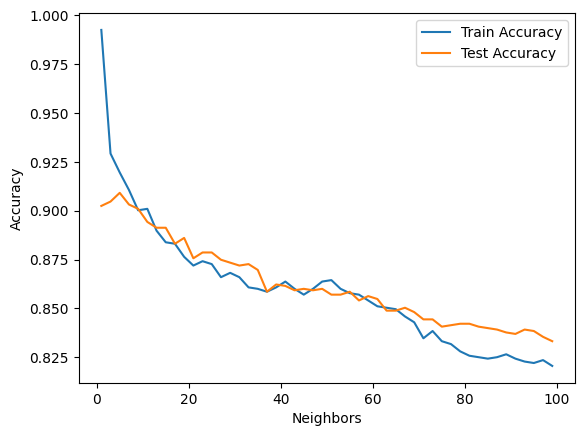

In [90]:
plt.plot(neighbors, train_accuracy, label = 'Train Accuracy')
plt.plot(neighbors, test_accuracy, label = 'Test Accuracy')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We have a separate testing dataset for this problem, so lets compute our accuracy there.

In [91]:
# read the test data, extract the info and create predictions
# note this dataset is different from the initial one
spam_test = pd.read_csv('https://github.com/barcelonagse-datascience/academic_files/raw/master/data/spam_small_test.csv')

X_test = spam_test.drop('class', axis = 1)
y_test = spam_test['class']

In [92]:
knnTest = KNeighborsClassifier(n_neighbors = neighbors[np.argmax(test_accuracy)]).fit(X, y)

knnPred = knnTest.predict(X_test)
knnProb = knnTest.predict_proba(X_test)
knnAcc = accuracy_score(y_test, knnPred)
knnAcc

0.8007322175732218

### CART(Classification and Random Tree)
### Linear models with tree-based features

To work our way towards tree-based models consider the following linear model with **tree-based features** 

As before, we have $\bf x_i=(x_{i\,1},\ldots,x_{i\,p})'$ . We can model the learning function as, 

$$f(\bf x_i;\beta) = \sum_{m=1}^M \beta_m 1[\bf x_i \in R_m]$$

where the $R_m$ are disjoint subsets of the input space defined by a binary tree. 
A generic partition and its corresponding binary tree could look like this (for $p=2$) (from the Hastie et al. book)
<table style="width:100%">
    <tr><th><img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/images/binary_tree.png"></th> 
        <th><img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/images/tree_subregions.png"></th></tr></table>

As an examle, suppose $p=2$ and we split each variable on its median.
We would have four regions: 
+ $R_1$: $x_1 \leq median(x_1)$ and $x_2 \leq median(x_2)$
+ $R_2$: $x_1 > median(x_1)$ and $x_2 \leq median(x_2)$
+ $R_3$: $x_1 \leq median(x_1)$ and $x_2 > median(x_2)$
+ $R_4$: $x_1 > median(x_1)$ and $x_2 > median(x_2)$

Tree-based methods are local approximation methods. We assume that the (unknown) $\mathbb E[y|X]$ can be locally (within each region) approximated by a constant. We can also predict with something other than a constant in each region, but we wont discuss that here.

If we know the regions $R_1,\dots,R_p$ this is simply a linear regression, as we have seen before.
In this case, each $\beta_m$ would be the average of $y$ in region $R_m$.

However, there are (at least) two main problems with this approach:

1. **Computational**: if we have $p$ variables there are $2^p$ regions if we split each variable in its median, hence we quickly end up with a massive number of features, which means our models will overfit unless we take precautions .

2. **Predictive**: even if we have carefully preselected the input variables in terms of their relevance for prediction, it might be the case that most of our features are not useful for prediction. On the other hand, for those that are relevant for prediction, there is no good reason why the median, or any preselected quantile, provides a good split. We would like to learn from the data itself where to split each variable (if used at all in the model); and maybe in order to get a good predictive model we might have to split some variables several times. Which now feeds back into the "computational" problem since the  potential regions might be much larger than $2^p$.

In comparison to the standard linear models, we now need to learn $\beta$ (the constant that we use in each region) but also the regions themselves. Without imposing more structure, this can become a very hard problem.

Luckily, if we stick to the square-loss that we have been using for regression, there are simplified solutions.
This is because for each region, the value of $\beta_m$ that minimizes the square loss is simply the average of $y$ over the region $R_m$. 

However, we still need to _learn_ ${\bf R}$. We will use a **greedy** algorithm:

+ Starting at the root node (with all our data), consider a splitting point $s$ and splitting variable $j$ partitioning our input space into

$$ R_1(j,s) = \{ X| X_j \leq s\} \hspace{2em} \text{and}\hspace{2em} R_2(j,s) = \{ X| X_j > s\} $$

+ Then, we look for $j$ and $s$ that minimize

$$ \sum_{x_i \in R_1(j,s)} \big(y_i - \text{ave}(y|x_i\in R_1) \big)^2 + \sum_{x_i \in R_2(j,s)} \big(y_i - \text{ave}(y|x_i\in R_2) \big)^2 $$

For each variable $j$, the determination of the split point $s$ can be done quickly (think of $x_i$ as sorted, start from the first index and go all the way to the last observation). Once we know the split points, we just need to choose the splitting variable $j$ that minimizes our objective.

+ We continue with this process iteratively until some criteria is met. 

Clearly, very large trees may overfit the data, whereas very small trees may not capture the relevant structure in the data.
+ One approach is to stop growing the tree when the number of observations falling in a new region is smaller than a number. This is known as the minimum node size.
+ Typically, we set a very small minimum node size (2 or 5) and perform **pruning** of the tree. **Pruning** is very relevant when using single decision trees, but we will typically use forests -- in which case pruning is less relevant.
+ Alternatively, we can directly control the _depth_ of the tree, or the number of regions we end up having.

### Tree based models: a first illustration

Lets fit a decision tree to the spam data. Recall that our objective is to classify emails as 'spam' or not-spam ('email'), based on the frequency that some words or expressions show up in this email.


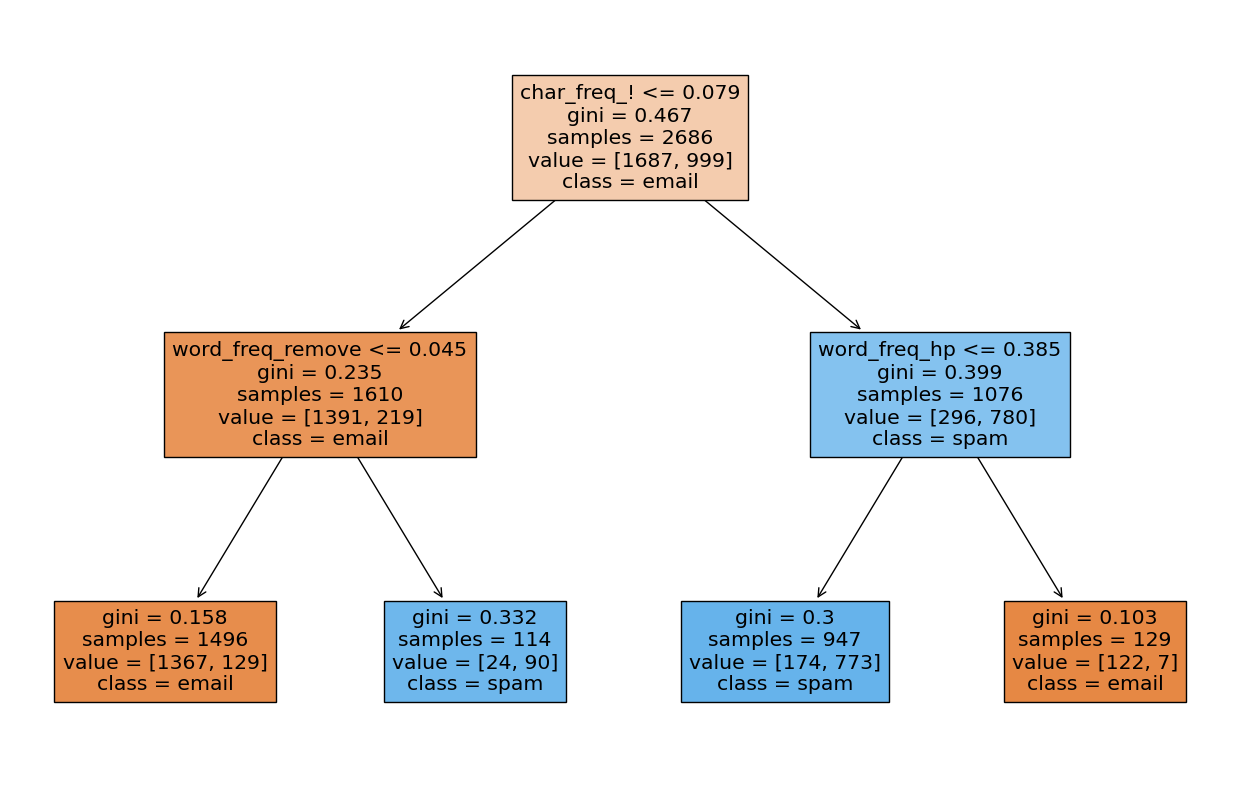

In [93]:
from sklearn.tree import DecisionTreeClassifier
# see also DecisionTreeRegressor

feature_names = X.columns
class_labels = ['email', 'spam']

# we start with a very simple tree
model = DecisionTreeClassifier(max_leaf_nodes = 4)
model.fit(X, y)

# plot the tree
plt.figure(figsize=(16, 10))
sklearn.tree.plot_tree(model,
                       feature_names = feature_names,
                       class_names = class_labels,
                       filled = True,
                       impurity = True)

plt.show()

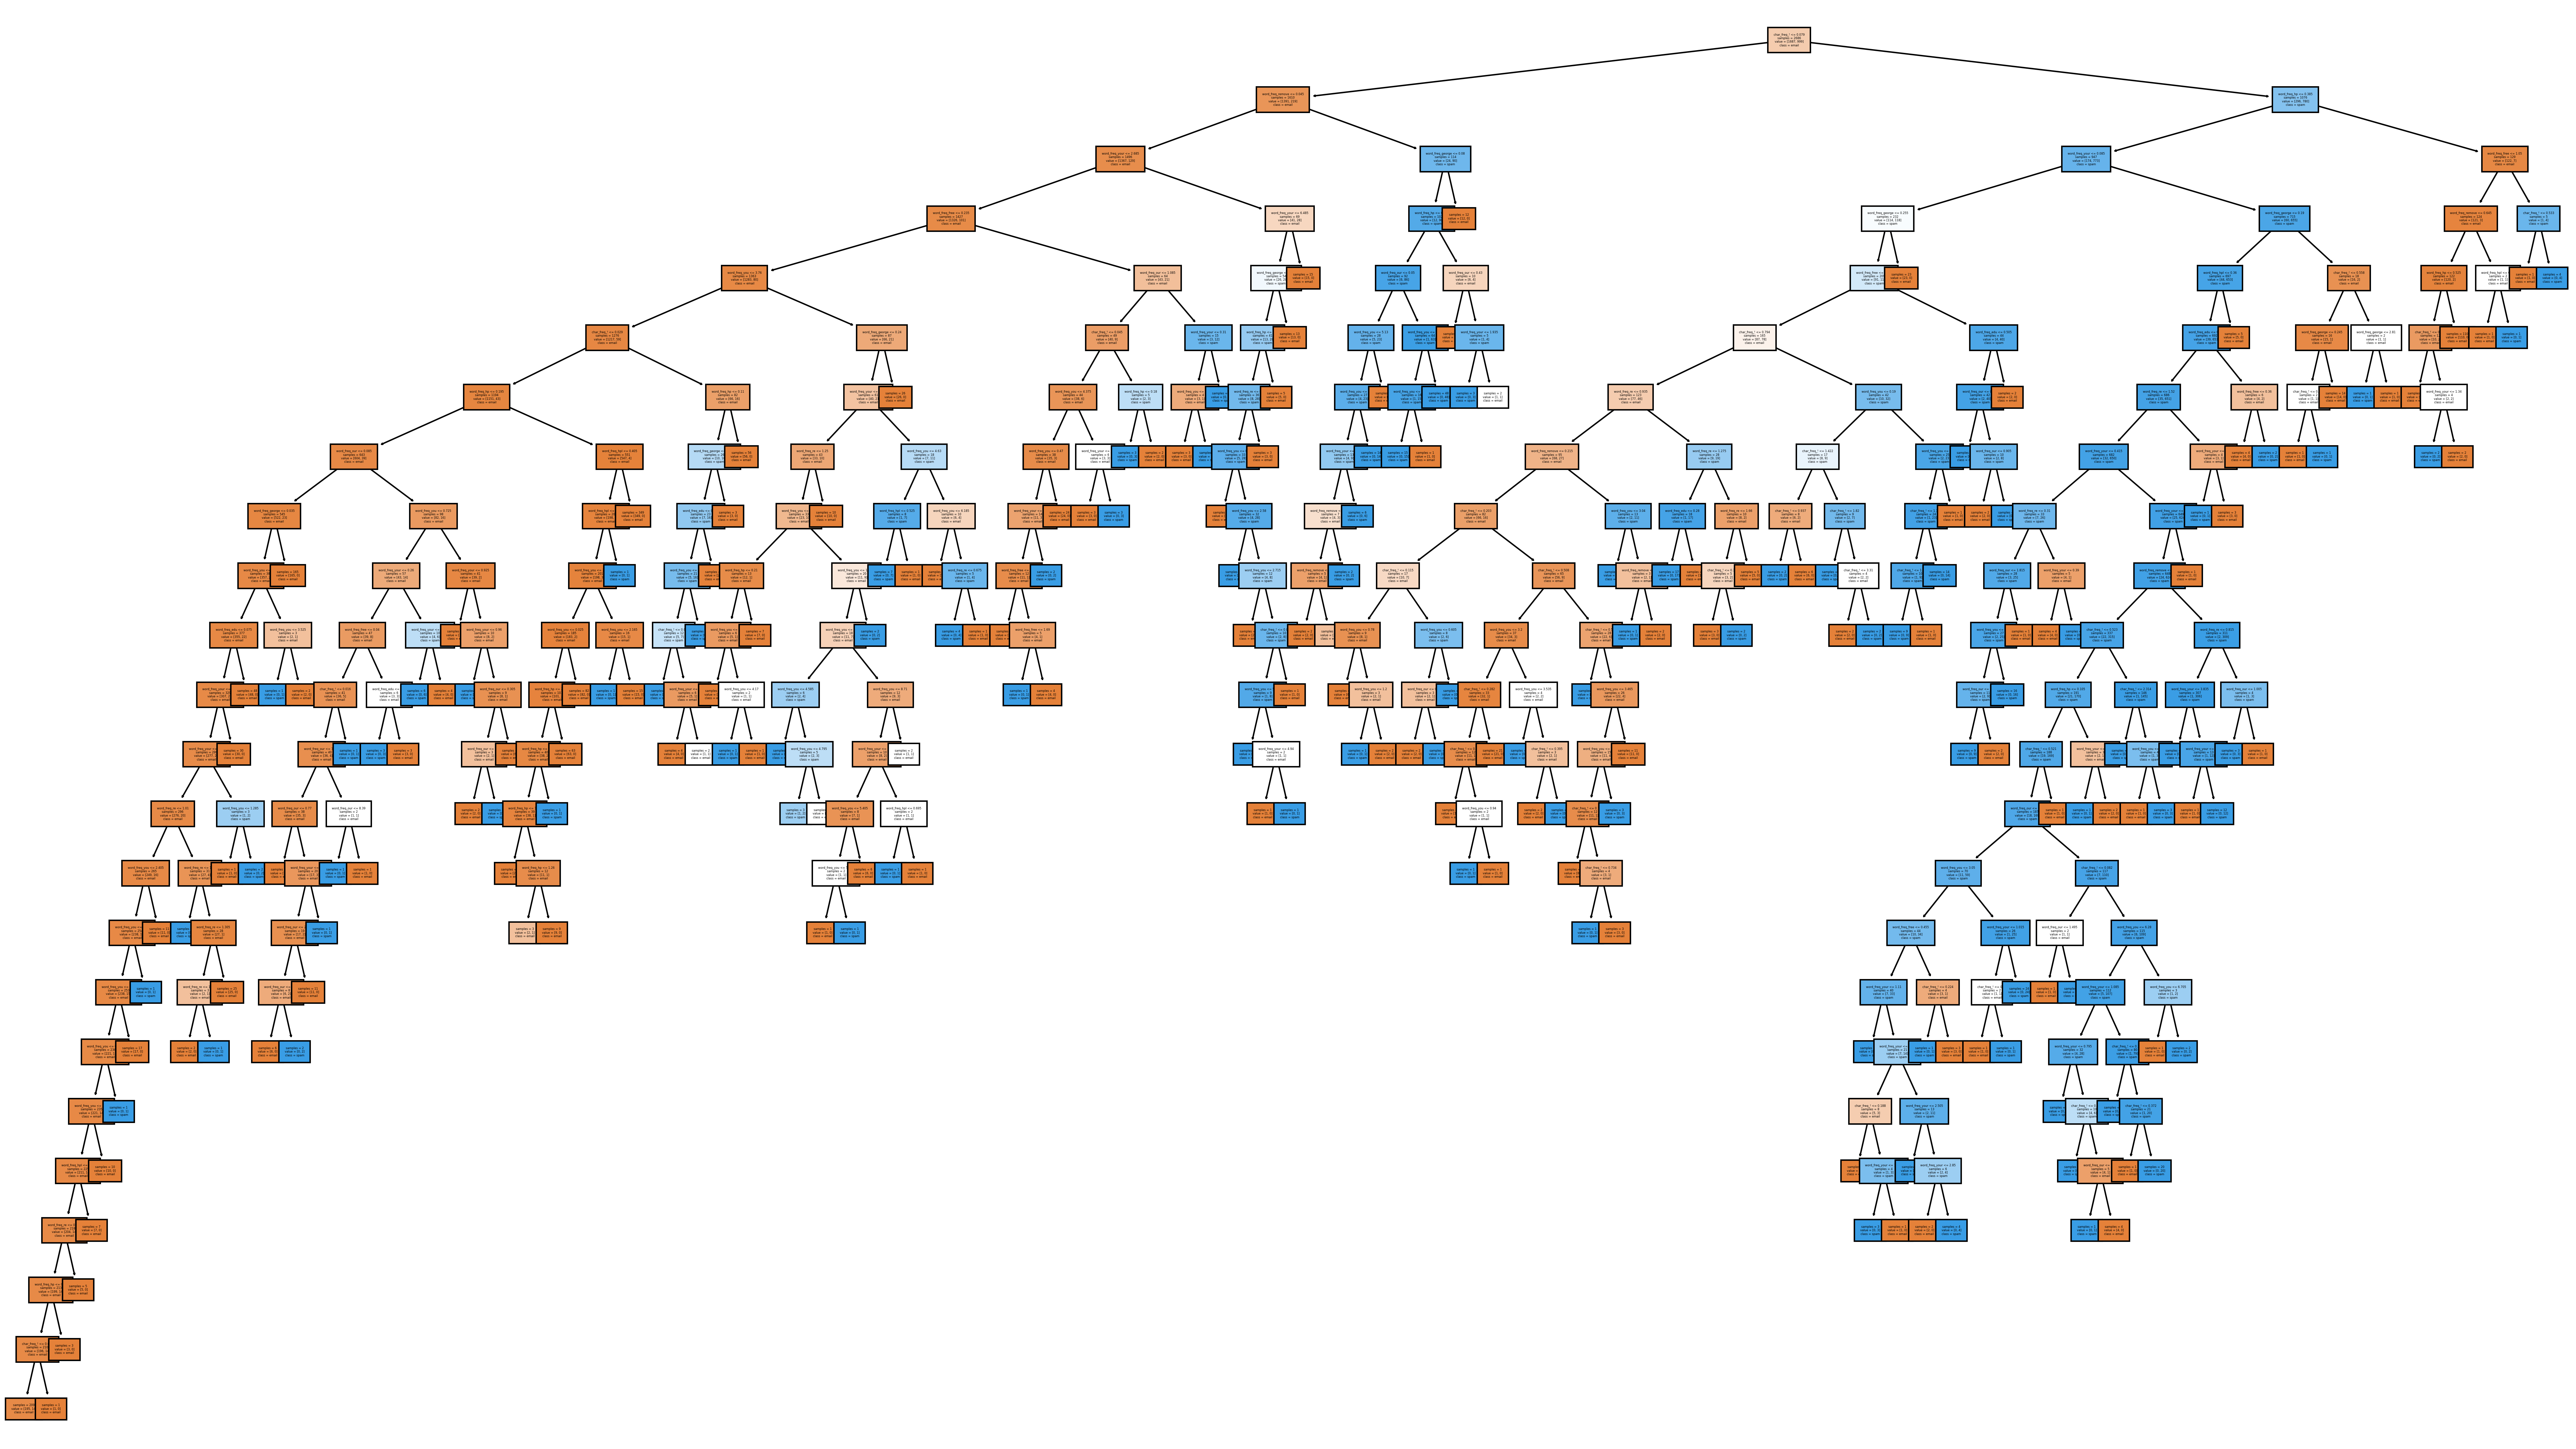

In [94]:
# lets see a more complex tree
model = DecisionTreeClassifier() # this will fit the tree untill a minimum nodesize of 2 is reached

model.fit(X, y) 
plt.figure(figsize=(32, 18), dpi = 300)
sklearn.tree.plot_tree(model,
                       feature_names = feature_names,
                       class_names = class_labels,
                       filled = True,
                       impurity = False,
                       fontsize = 2)
plt.show()

Note the complexity of this tree. Forks to the right imply `false` in the splitting criteria, forks to the left are `true`. Orange colors means the output is `no spam`, whereas blue colors mean `spam`. 

Spam is predominantly in the right hand side of the tree. You can zoom into the figure by saving (right-clicking) and opening elsewhere.


In [95]:
# compute predictions for training data
pred = model.predict_proba(X)

# compute prediction for testing data
test_pred = model.predict_proba(X_test)

# just to remind which class is in which column of our predictions
print(model.classes_)
test_pred


[0 1]


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

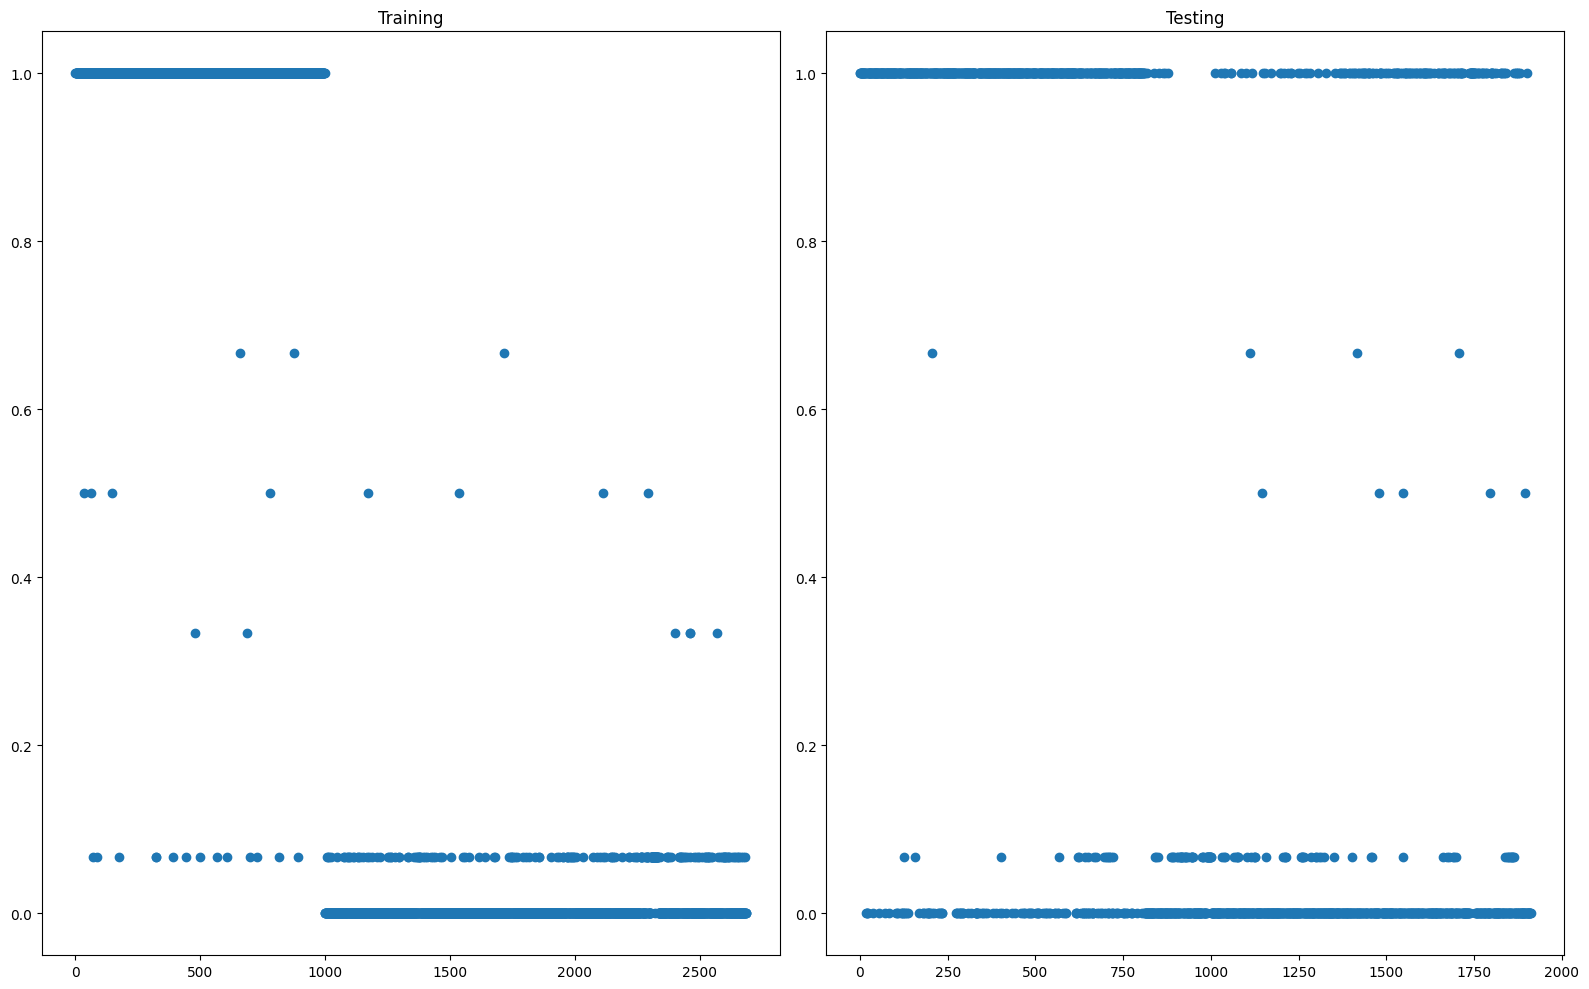

In [96]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,
                               ncols = 2,
                               figsize = (16, 10))

# the probabilitiy of message being spam in the training set
ax1.plot(pred[:, 1], 'o')
ax1.set_title('Training')

# the probability of message being spam in the testing set
ax2.plot(test_pred[:, 1], 'o')
ax2.set_title('Testing')

fig.tight_layout()
plt.show()

The model predicts 'spam' or 'email' with apparently high confidence on its results (probabilities close to 0 or 1, few points in between).

### AUC recap
Recall that we use the Area Under the Curve (**AUC**) and **ROC** to evaluate performance of binary classification models.
Remember that ROC is a probability curve and AUC represents degree or measure of separability. It tells how much our model is capable of distinguishing between classes if we use different thresholds of probability. In general, the higher the AUC (from 0 to 1), the better the model is at predicting a binary classification (in this case 'spam' and 'email')
The curve plots the relationship between True Positive Rate and False Positive Rate, having these definitions:

$TPR=\frac{TP}{TP+FN}$

$FPR=\frac{FP}{FP+TN}$

Lets see the ROC and AUC in our training sample:

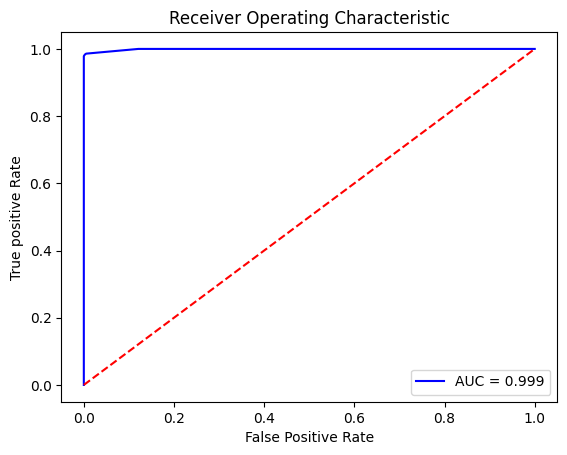

In [97]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y, pred[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3F' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.show()

This is effectively what we would like to see from a classifier. It looks great! maybe **too** good? Lets look at the test set

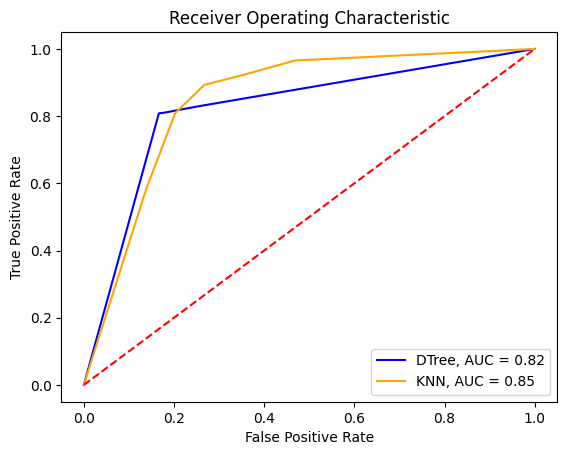

In [98]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, test_pred[:, 1])
fpr_knn, tpr_knn, threshold_knn = sklearn.metrics.roc_curve(y_test, knnProb[:, 1])

roc_auc = sklearn.metrics.auc(fpr, tpr)
roc_auc_knn = sklearn.metrics.auc(fpr_knn, tpr_knn)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'DTree, AUC = %0.2F' % roc_auc)
plt.plot(fpr_knn, tpr_knn, 'orange', label = 'KNN, AUC = %0.2F' % roc_auc_knn)

plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The classifier still performs quite well on the test sample, but clearly we were *too optimistic* in our in sample evaluation. Also note that we did not tune any of our parameters. We will do that in what follows.

### Compexity, Accuracy and Overfitting

Here we show *overfitting* risk: allowing a decreasing minimum node size we increase the accuracy on training data, but not necessarily increase accuracy when applying to new (test) data. 

By grid-searching the tuning parameter 'max_leaf_nodes' (the number of regions considered), we can estimate the optimum value to avoid overfitting.

In [99]:
# keep the results in a list
complexity_value = []
test_accuracy = []
train_accuracy = []

# loop through possible values of max_leaf_nodes
for max_leaf_nodes in range(2, 500, 5):
  model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes)
  model.fit(X_train, y_train)
  
  # predict both on train and test set
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store the data to be used for plotting
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  test_accuracy.append(accuracy_score(y_val, y_pred))
  complexity_value.append(max_leaf_nodes)

In [100]:
print('Best accuracy: ', max(test_accuracy), 'at max_leaf_nodes = ', complexity_value[np.argmax(test_accuracy)])

Best accuracy:  0.9262844378257632 at max_leaf_nodes =  67


Text(0, 0.5, 'Accuracy')

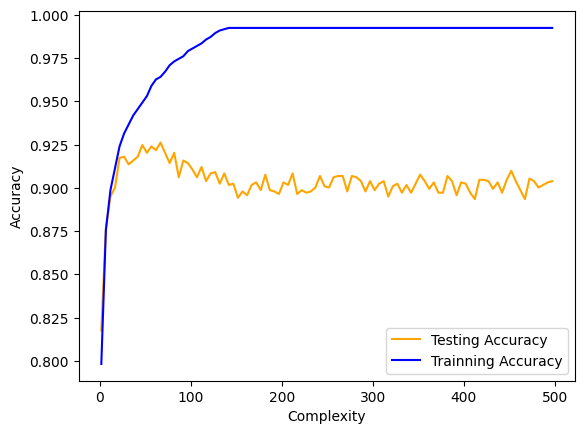

In [101]:
plt.plot(complexity_value, test_accuracy, 'orange', 
         label = 'Testing Accuracy')
plt.plot(complexity_value, train_accuracy, 'b',
         label = 'Trainning Accuracy')
plt.legend()
plt.xlabel('Complexity')
plt.ylabel('Accuracy')

In [102]:
DtreeTunned = DecisionTreeClassifier(max_leaf_nodes = complexity_value[np.argmax(test_accuracy)])

DtreeTunned.fit(X, y)
DtreePred = DtreeTunned.predict(X_test)
Dtreeprob = DtreeTunned.predict_proba(X_test)
DtreeAcc = accuracy_score(y_test, DtreePred)

(knnAcc, DtreeAcc)

(0.8007322175732218, 0.8519874476987448)

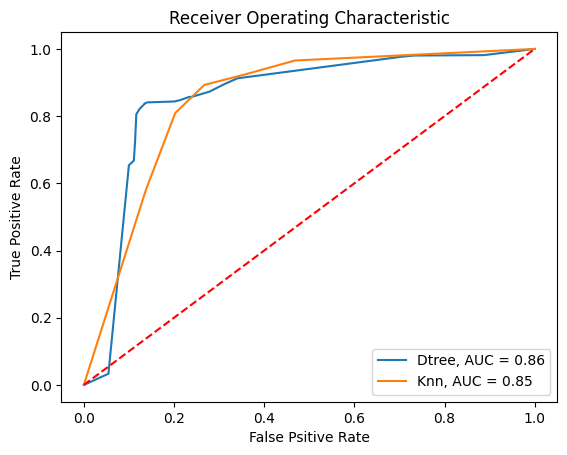

In [103]:
fpr_Dt, tpr_Dt, threshold_Dt = sklearn.metrics.roc_curve(y_test, Dtreeprob[:, 1])
fpr_knn, tpr_knn, threshold_knn = sklearn.metrics.roc_curve(y_test, knnProb[:, 1])

roc_auc_Dt = sklearn.metrics.auc(fpr_Dt, tpr_Dt)
roc_auc_knn = sklearn.metrics.auc(fpr_knn, tpr_knn)

plt.plot(fpr_Dt, tpr_Dt, label = 'Dtree, AUC = %0.2f' % roc_auc_Dt)
plt.plot(fpr_knn, tpr_knn, label = 'Knn, AUC = %0.2f' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Psitive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Implicit variable selection and scoring

Decision trees effectively perform selection, since some variables never get chosen for a split. The model also provides the _importance_ of each _active_ variable. 
At each split in the tree, the improvement in the loss resulting from this split is calculated. The importance of a given variable is the sum of this improvement over all splits on this variable.

Typically, feature importance is presented by standardization: we scale all feature by the most important one.

In [104]:
model = DecisionTreeClassifier(max_leaf_nodes = 20)
model.fit(X, y)
important_feature = pd.DataFrame(model.feature_importances_/model.feature_importances_.max(),
                                 index = X.columns,
                                 columns = ['importance'])

important_feature.sort_values('importance', ascending = False) 

importance
char_freq_!         1.000000
word_freq_hp        0.288664
word_freq_remove    0.250218
word_freq_your      0.173512
word_freq_george    0.138074
word_freq_free      0.048394
word_freq_re        0.030328
word_freq_hpl       0.019356
word_freq_our       0.019102
word_freq_you       0.013581
word_freq_edu       0.000000

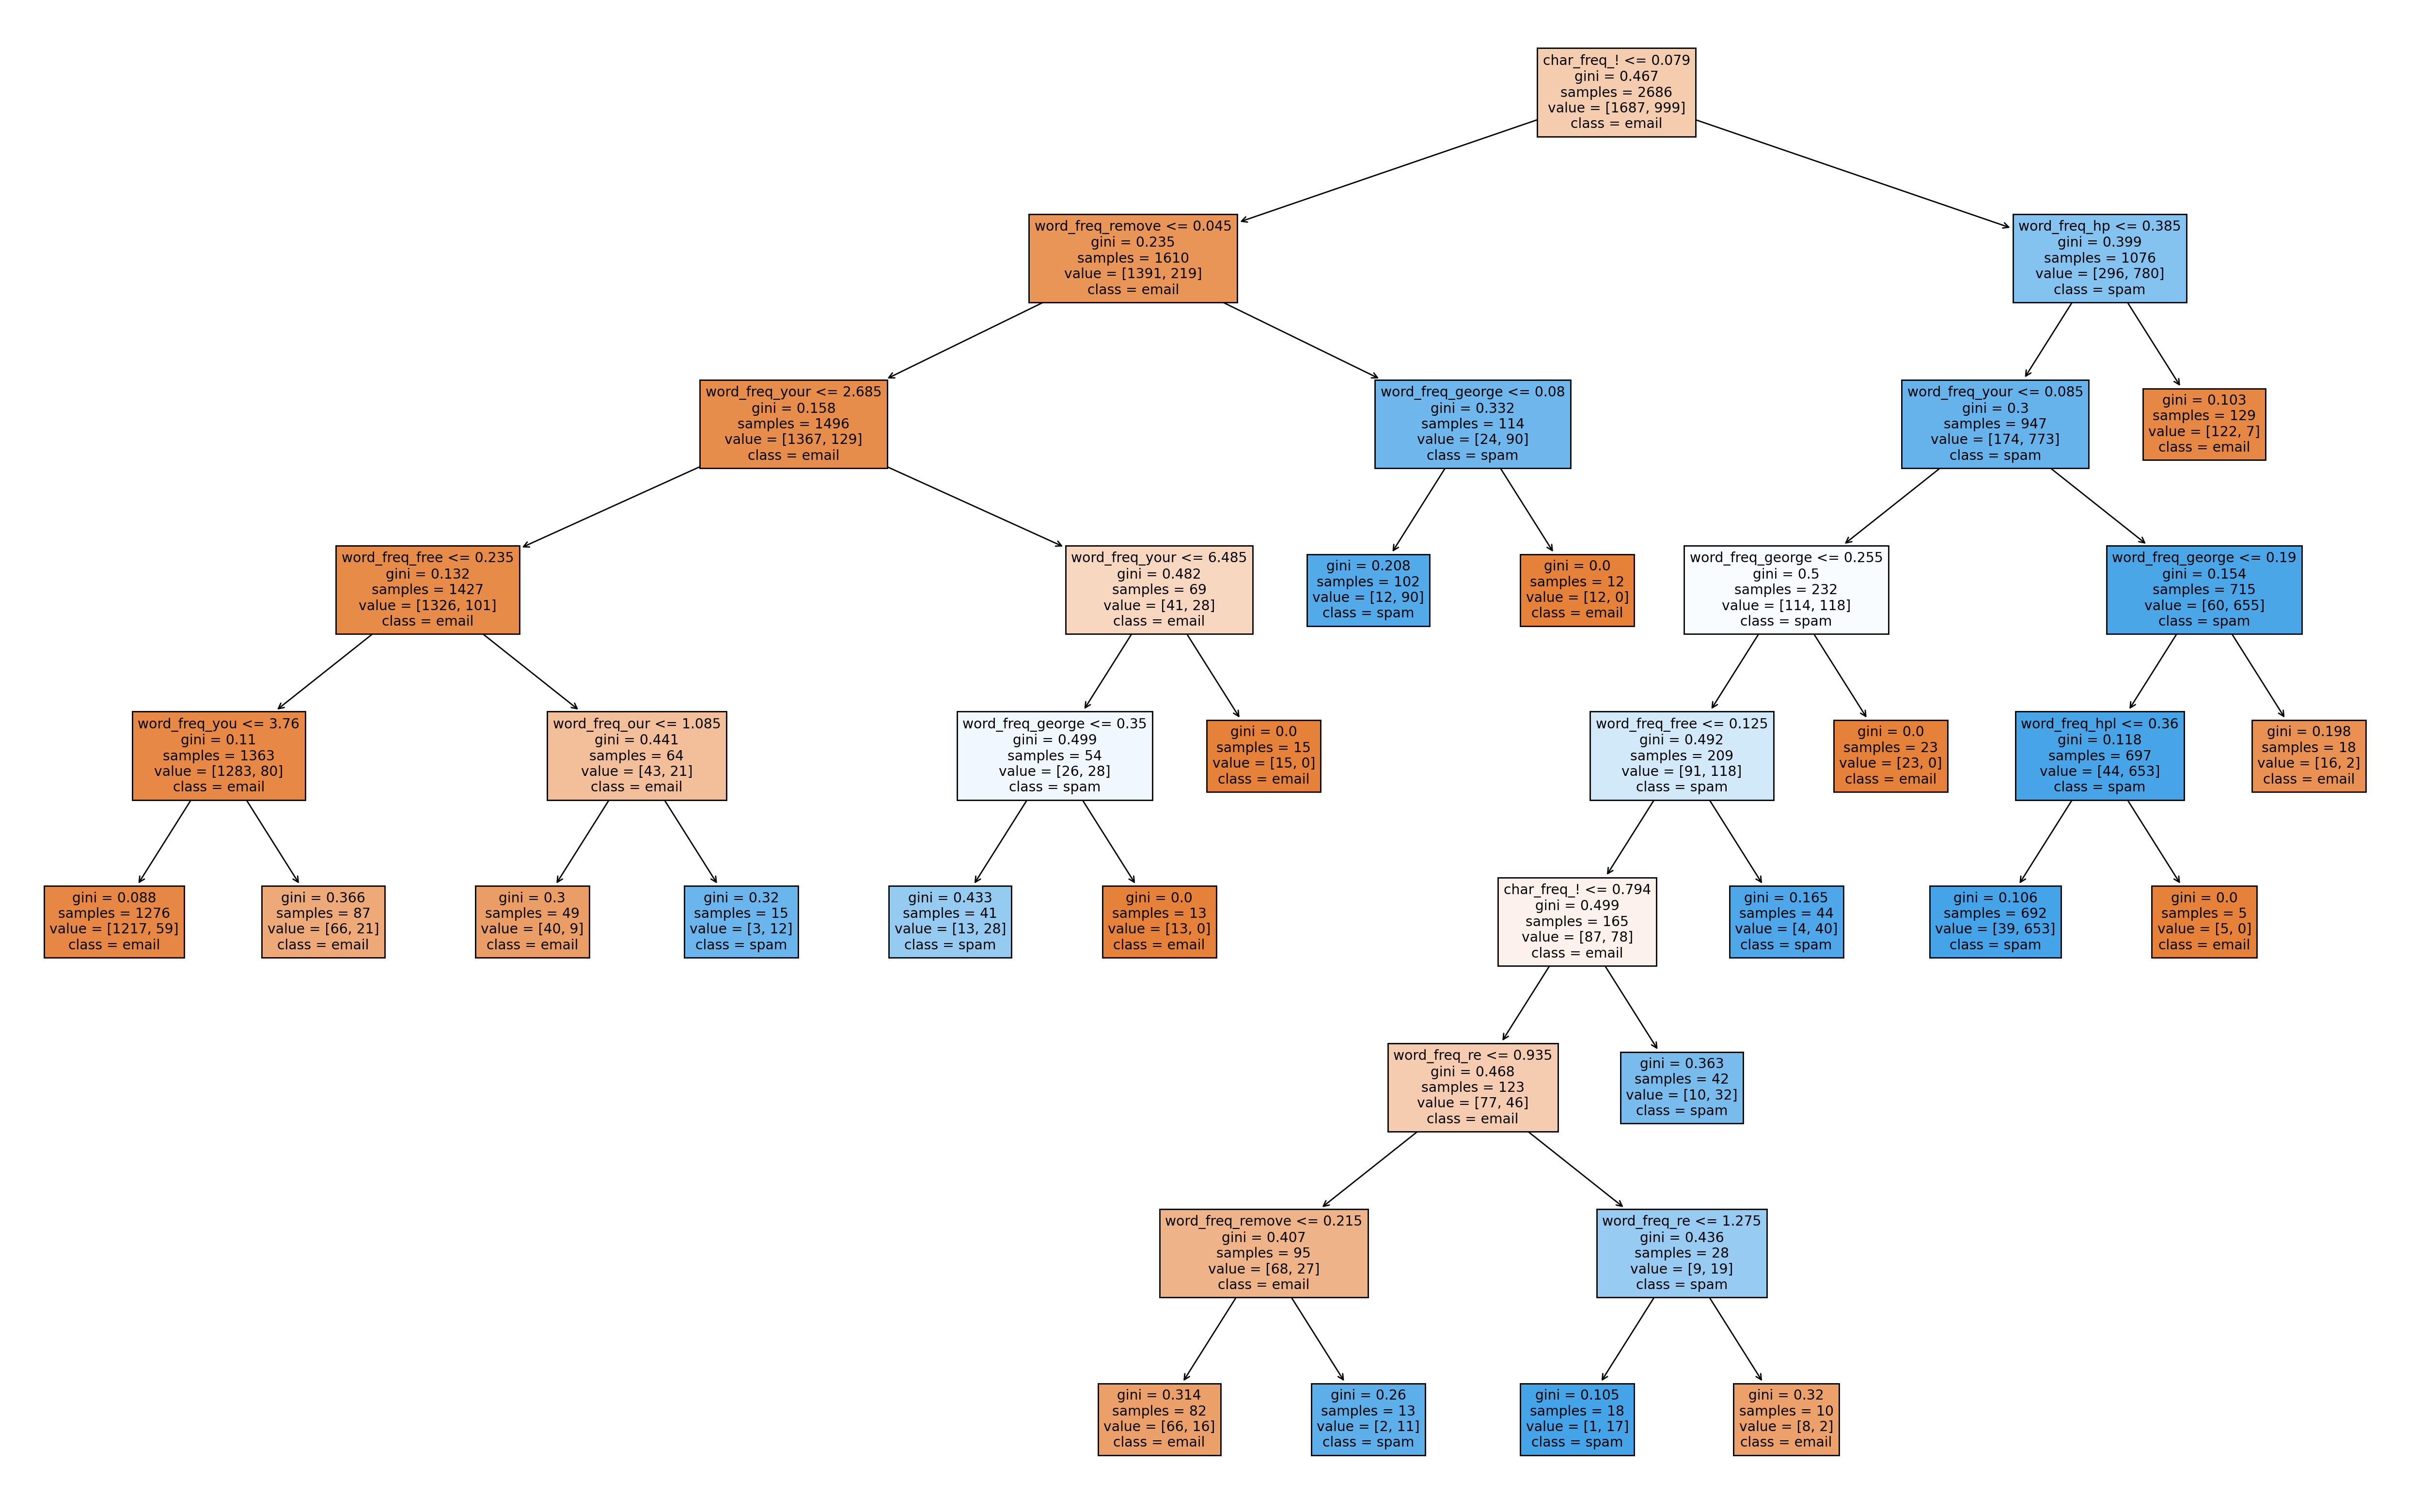

In [105]:
# lets plot the tree too
plt.figure(figsize = (32, 20), dpi = 200)
sklearn.tree.plot_tree(model, 
                       feature_names = feature_names,
                       class_names = class_labels,
                       filled = True)
plt.show()

As we move down the tree, we decrease the impurity measure, meaning we are separating more and more the classes.

### Stability 

Lets see how stable the previous results are to different subsets of the data

In [106]:
# the maximal test accuracy achieved for each split
test_accuracy_argmax = []
# the variable char_! importance
importance_char = []
test_accuracy_max = []

# bootstrap sampling
for bootsam in np.arange(100):
  # split randomly dataset; don't fix the seed to see variation
  X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X, y, test_size = 0.2)
  
  #varing depth
  test_accuracy = []
  complexity_value = []
  for max_leaf_nodes in np.arange(5, 100, 5):
    model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes)
    model.fit(X_train_bs, y_train_bs)
    y_pred_bs = model.predict(X_test_bs)
    test_accuracy.append(accuracy_score(y_test_bs, y_pred_bs))
    complexity_value.append(max_leaf_nodes)
  #
  test_accuracy_argmax.append(complexity_value[np.argmax(test_accuracy)])
  test_accuracy_max.append(max(test_accuracy))  
  
  model = DecisionTreeClassifier(max_leaf_nodes = complexity_value[np.argmax(test_accuracy)])
  model.fit(X_train_bs, y_train_bs)
  important_feature = pd.DataFrame(model.feature_importances_/model.feature_importances_.max(), index = X.columns, columns = ['importance'])
  importance_char.append(important_feature.loc['char_freq_!', :].values[0])

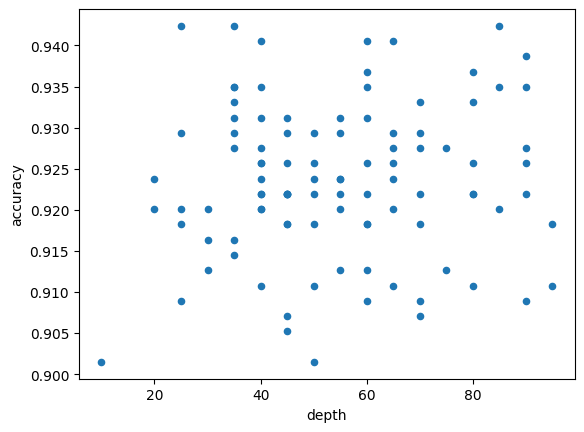

depth  socre_char    accuracy      leaves
count  100.000000       100.0  100.000000  100.000000
mean    54.500000         1.0    0.923457   54.500000
std     19.777806         0.0    0.009409   19.777806
min     10.000000         1.0    0.901487   10.000000
25%     40.000000         1.0    0.918216   40.000000
50%     52.500000         1.0    0.922862   52.500000
75%     70.000000         1.0    0.929368   70.000000
max     95.000000         1.0    0.942379   95.000000

In [107]:
# print the results in a convenient manner
result = pd.DataFrame(test_accuracy_argmax, columns = ['depth'])
result['socre_char'] = importance_char
result['accuracy'] = test_accuracy_max
result['leaves'] = test_accuracy_argmax
result.plot(x = 'depth', y = 'accuracy', kind = 'scatter')
plt.show()
result.describe()

It seems like _char_freq_!_ is a very relevant variable, but the number of leaves oscillates quite a bit, and performance does depend on that.

### From tree to forest: Bagging and random forests

The earlier experiment that grew a tree-based model on different subsets of the data revealed an important aspect of tree-based models, that of *instability*, small changes in the data (e.g. removing 20% of observations) causes large changes in the estimated model.

Here is another example with some simulated data from Hastie, Tibshirani and Friedman book

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master//images/bagged_trees.png"> 


This is typical of an estimator with high variance. Recall the bias-variance tradeoff in ML.

One way to deal with the bias variance tradeoff is by using _ensemble_ methods that average over many (typically) unbiased models with high (typically) variance. One way to do so is by bootstrap aggregation, or 
**Bagging**. 

**Bagging** takes many bootstrap samples from the original data, estimates a model on the _bagged_ sample, and constructs an _ensemble_ with all the _bagged_ samples. The resulting learned function is no longer a decision tree, but a linear combination of $K$ such trees.


Bagging does not change the bias of the underlying estimator, but it can decrease its variance improving predictive performance. 

This is what happens on the same simulated dataset of Hastie, Tibshirani and Friedman

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/bagged_trees_error.png">

The tree-based estimators from each bootstrap sample are generally correlated with each other: they have access to very similar datasets in terms of features.

If all bagged trees are strongly correlated, we should not expect any advantages from bagging. 
Hence, we should try to produce tree-based estimators with as little correlation between them as possible.
This is what *random forests* set out to do, by forcing the growth of trees where each splitting variable is selected from a _random_ draw of features. This reduces correlation by introducing potentially different splitting variables.


Algorithmically, _random forests_ require a small change to the CART algorithm used for growing trees.
First, the trees are grown on bagged samples. Then, instead of considering all variables as candidates for splitting, _random forests_ chooses a random subset of features for each split time and consider only those. The resultant trees, one for each bootstrap sample, are averaged to produce the random forest estimator 

### Random forests in sklearn

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# set seed for reproducibility
np.random.seed(2022)

forest = RandomForestClassifier(n_estimators = 100) # number of trees
scores = cross_val_score(forest, X, y, cv = 5)
print('Acuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

importances = forest.fit(X, y).feature_importances_
important_features = pd.Series(data = importances/importances.max(),
                               index = feature_names)
important_features.sort_values(ascending = False)

Acuracy: 0.93 (+/- 0.02)


char_freq_!         1.000000
word_freq_your      0.522911
word_freq_remove    0.500879
word_freq_free      0.429305
word_freq_hp        0.404296
word_freq_you       0.343212
word_freq_george    0.231318
word_freq_our       0.226208
word_freq_hpl       0.144826
word_freq_re        0.137738
word_freq_edu       0.038538
dtype: float64

A more detailed look at tuning parameters

In [109]:
features = []
test_accuracy = []
train_accuracy = []

for max_features in range(1, 11, 1):
  model = RandomForestClassifier(max_features = max_features, 
                                 random_state = 44)
  model.fit(X_train, y_train)
  
  # predict both on train and test set
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store data to be used for plotting
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  test_accuracy.append(accuracy_score(y_val, y_pred))
  features.append(max_features)
  
  

In [110]:
print('Best accuracy: %0.2f' % max(test_accuracy), 'at maximum features = ', features[np.argmax(test_accuracy)])

Best accuracy: 0.94 at maximum features =  2


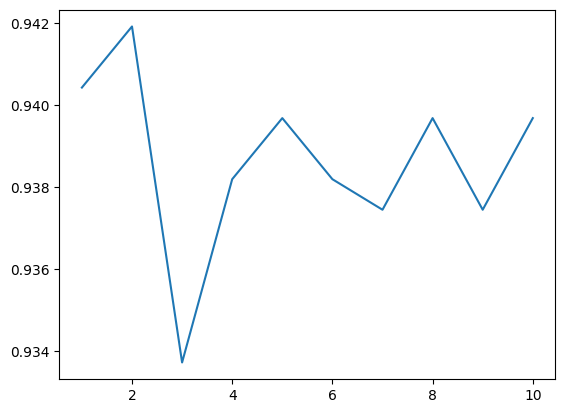

In [111]:
# plot
plt.plot(features, test_accuracy)

In [112]:
ntrees = []
test_accuracy = []
train_accuracy = []

for tree in range(10, 1000, 100):
  model = RandomForestClassifier(max_features = 2,
                                 n_estimators = tree,
                                 random_state = 44)
  model.fit(X_train, y_train)
  
  # predict
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  test_accuracy.append(accuracy_score(y_val, y_pred))
  ntrees.append(tree)


In [113]:
print('Best accuracy is: %0.2f' % max(test_accuracy), 'at ntrees = %s' % ntrees[np.argmax(test_accuracy)])

Best accuracy is: 0.94 at ntrees = 110


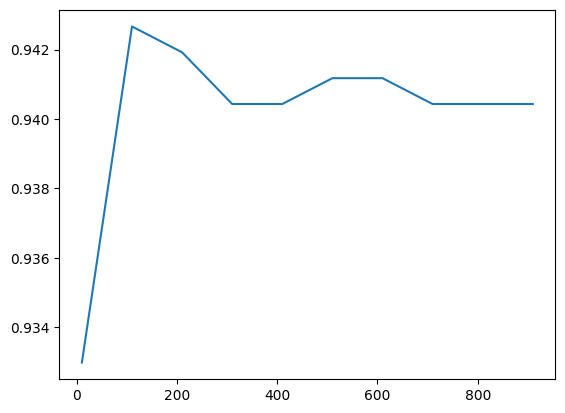

In [114]:
# plot
plt.plot(ntrees, test_accuracy)

In [115]:
# use tuned model to predict
RFTuned = RandomForestClassifier(max_features = 2,
                                 n_estimators = 110,
                                 random_state = 44)
RFTuned.fit(X, y)
RFPred = RFTuned.predict(X_test)
RFprob = RFTuned.predict_proba(X_test)
RFAcc = accuracy_score(y_test, RFPred)

knnAcc, DtreeAcc, RFAcc

(0.8007322175732218, 0.8519874476987448, 0.8739539748953975)

Text(0, 0.5, 'True Positive Rate')

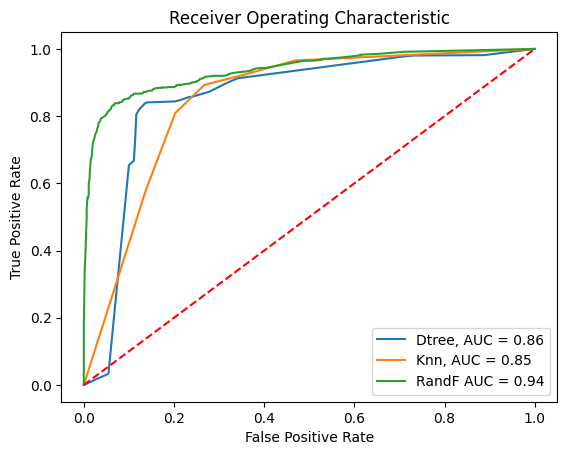

In [116]:
fpr_rf, tpr_rf, threshold_rf = sklearn.metrics.roc_curve(y_test, RFprob[:, 1])

roc_auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_Dt, tpr_Dt, label = 'Dtree, AUC = %0.2f' % roc_auc_Dt)
plt.plot(fpr_knn, tpr_knn, label = 'Knn, AUC = %0.2f' % roc_auc_knn)
plt.plot(fpr_rf, tpr_rf, label = 'RandF AUC = %0.2f' % roc_auc_rf)
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Random forests: comments
+ When the number of predictors is large, but the number of _relevant_predictors is small, random forests is likely to struggle (for low `max_features` parameter). Can you see why?

+ Tree growing procedures: while one could control the complexity of each tree in the forest, there is little to be gained by doing so. This is because bagging will likely _average out_ the overfitting induced by complex trees.

+ Moreover, the bias of an iid ensemble is equal to the bias of each component and complex trees have (typically) small bias but high variance. (Although the bias of a single tree will typically be smaller than that of a random forest tree due to the induced randomness (not training over the whole sample, nor with access to all features)

+ The control of variance is obtained through the averaging: the variance of an average of $n$ iid variables is $\frac{1}{n}\sigma_i^2$. Although this changes if the ensemble is just identically (but not independently) distributed, the idea is the same. In fact, the variance of the ensemble will have a $\frac{1}{n}$ term and a term that depends on the correlation between all such trees. 

$$ \frac{1-\rho(m)}{M}\sigma^2 + \rho(m) \sigma^2$$



### Boosting 

Boosting is a very powerful tool that combines many _weak learners_ (classifiers that just slightly outperform random guessing) into a powerful _committee_.

The idea of boosting is to sequentially apply the _weak learner_ to repeatedly modified versions of the dataset, producing a sequence $m=1,\dots,M$ of weak learners, whose predictions are then combined through a weighted majority vote.

Each version of the modified dataset is constructed by _reweighting upwards_ observations for which the weak learner $m-1$ failed to predict, and decreasing the weights on observations that are already correctly predicted. **At each step of boosting, the weak learner is forced to give increasing emphasis to the difficult observations**. Before we go into more detail, lets see the algorithm:



1. Initialize observations weights $w_i = \frac{1}{n}$ for all $i=1,\dots,n$.

2. for $m=1$ to $M$:

  + 2.1 Fit a classifier $G_m(x)$ to the training data using the weights $w_i$.

  + 2.2 Compute:
  $$ err_m = \frac{\sum_{i=1}^n \textbf{1}(y_i \neq G_m(x_i))}{\sum_{i=1}^nw_i}$$
  
  + 2.3 Compute:
  $$ \alpha_m = log( (1-err_m)/err_m))$$

  + 2.4 update: for $i=1,\dots,n$.
  $$ w_i \leftarrow w_i \exp( \alpha_m\textbf{1}(y_i \neq G_m(x_i))$$
   

3. Output $G(x)= \text{sign}(\sum_{m=1}^M \alpha_m G_m(x))$



For example, if the error rate of the first round is, say, 0.49. The missclassified observations get reweighted up by $0.51/0.49 \approx 1.05$

### Tuning parameters for boosting trees
In practice, we typically consider trees as the _weak learners_ in boosting. 
In such cases, we will have the following tuning parameters.

### Number of boosting steps (or trees to grow)
The first tuning parameter to consider for boosting is the number of boosting steps $M$ to take (or, equivalently, the number of trees to grow). Typically, we can make the training error arbitrarily small by growing a sufficient number of trees. We have already seen that good training performance does not necessarily translate to good testing performance, so this is a tuning parameter that has to be decided.

### How large should we grow each tree
As in the case for trees, we have to carefully choose how large we want our trees to be. If we fully grow trees at each boosting stage, we may end up paying a price in terms of variance. In fact, a good strategy is to grow, at each boosting step, very simple trees with few terminal nodes (default in sklearns gbm is 3).

### Shrinkage / Learning Rate
In addition to controlling the number of trees and the size of the trees, we can regularize the contribution of each tree by $\epsilon \in (0,1]$. In our setup, this can be better seen as 
$$ f_m(x,\theta,\beta) = f_{m-1}(x,\theta,\beta) + \epsilon\theta_m f_m(x,\beta_m) $$

So the contribution of each tree is reduced. Note that there is a tradeoff between $\epsilon$ and $M$. This is typically called the learning rate of the algorithm: smaller values of $\epsilon$ lead to higher training error (for fixed $M$), and so these are _slow_ learners.






### Possibilities

#### Adaboost (The algorithm we saw above)
Forward search for heuristic optimization: fit the model one term at a time. Combined with the exponential loss, $L(y_i,f(x_i)) = e^{-y_i f(x_i)}$, this yields the so-called *AdaBoost* (Adaptive Boosting). Main highlights of AdaBoost are that:

+ Each tree is a simple 'decision stump', so only one node per tree (really weak classifier);
+ Each iteration we re-weight observations, up-weighting the ones with lower accuracy in previous trees.

#### GBM
Gradient-based minimization: this yields *gradient boosting*. GBM divides the optimization problem into two parts by first determining the direction of the step and then optimizing the step length. The main formulation is as follows:

$$f_m(\bf x)=f_{0}(\bf x)+ \sum_{m=1}^M \epsilon \rho_m   \phi_m(\bf x)$$
Where, for each new tree *m*, $\phi_m(x)$ is optimized as direction of step giving best gradient in the loss function (considering m-1 trees):
$$\phi_m(\bf x)= arg min_{\phi} \sum_{i=1}^n \left[ (-g_m(\bf x_i)) - \phi(\bf x_i) \right]^2 $$
being $g_m$ the negative gradient of the loss function:
$$-g_m(\bf x)= - \left[ \frac{\partial L(y, f(\bf x))}{\partial f(\bf x)} \right]  $$
As an example, for each particular observation, in a regression problem, this gradient is how much the loss would change if we increase by one unit our prediction for this observation.

Next, $\rho$ is the optimized *step_length* (via line search):
$$\rho_m(\bf x)= arg min_{\rho} \sum_{i=1}^n L(y_i, f^{m-1}(\bf x_i)+ \rho \phi_m(\bf x_i))  $$

#### Stochastic Gradient Boosting

At each iteration, stochastic gradient boosting trains the new tree on a bagged sample of the data. This is computationally better than on the whole dataset, and it may also provide gains due to its ability to prevent overfitting.

#### Xgboost

https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Extreme Gradient Boosting (*XGBoost*): Similar to GBM but each iteration solves the gradient search in one single step using Taylor expansion of the gradient formula. On the other hand, it uses a more regularized model formalization to control over-fitting , which typically implies better performance.



#### Caveats
Over-specialization: trees added at later iterations tend to impact the prediction of only a few observations, so that their contribution towards the rest of the dataset becomes negligible. This is only addressed by Extreme Gradient Boosting model, by using regularization.


**Lets see boosting in action for the spam data**

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

# set seed
np.random.seed(44)

# number of boosting stages = number of trees to grow
tree = GradientBoostingClassifier(n_estimators = 100)
scores = cross_val_score(tree, X, y, cv = 5, scoring = 'roc_auc')
print('Accuracy: %0.3f (+/- %0.3f)' % (scores.mean(), scores.std()*2))

importance = tree.fit(X, y).feature_importances_
important_features = pd.Series(data = importance/importance.max(),
                               index = feature_names)
important_features.sort_values(ascending = False)

Accuracy: 0.972 (+/- 0.011)


char_freq_!         1.000000
word_freq_hp        0.436406
word_freq_remove    0.305717
word_freq_your      0.222952
word_freq_free      0.207087
word_freq_george    0.188304
word_freq_you       0.045294
word_freq_our       0.040572
word_freq_re        0.027026
word_freq_edu       0.025859
word_freq_hpl       0.011309
dtype: float64

For this dataset, it seems that gradient boosting performs better than random forests.

In [118]:
complexity_value = []
test_accuracy = []
train_accuracy = []

for depth in range(1, 20, 1):
  model = GradientBoostingClassifier(max_depth = depth,
                                     random_state = 44)
  model.fit(X_train, y_train)
  
  # predit
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  test_accuracy.append(accuracy_score(y_val, y_pred))
  complexity_value.append(depth)


In [119]:
print('Best accuracy: %0.3f' % max(test_accuracy), 'at depth = %s' % complexity_value[np.argmax(test_accuracy)])

Best accuracy: 0.942 at depth = 6


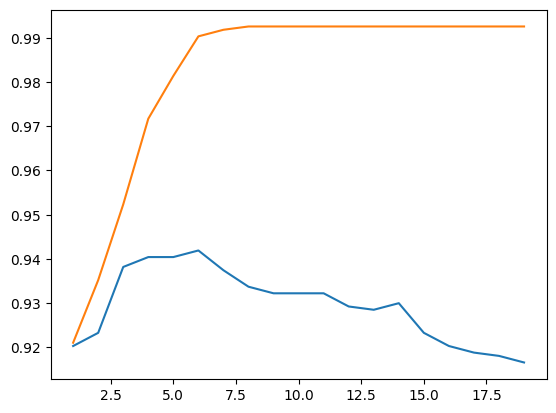

In [120]:
# plotting
plt.plot(complexity_value, test_accuracy)
plt.plot(complexity_value, train_accuracy)

In [121]:
ntrees = []
test_accuracy = []
train_accuracy = []

for trees in range(50, 1000, 100):
  model = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = trees,
                                     random_state = 44)
  model.fit(X_train, y_train)
  
  # predict
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store
  test_accuracy.append(accuracy_score(y_val, y_pred))
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  ntrees.append(trees)

In [122]:
print('Best accuracy: %0.3f' % max(test_accuracy), 'at ntrees = %s' % ntrees[np.argmax(test_accuracy)])

Best accuracy: 0.942 at ntrees = 150


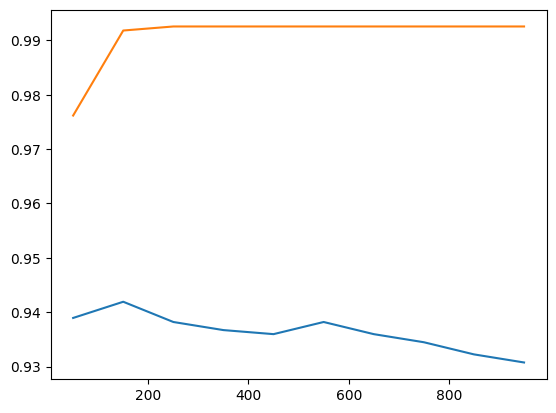

In [123]:
# plot 
plt.plot(ntrees, test_accuracy)
plt.plot(ntrees, train_accuracy)

In [124]:
learning_rate = []
test_accuracy = []
train_accuracy = []

for shrinkage in np.linspace(0.001, 1, 50):
  model = GradientBoostingClassifier(max_depth = 6,
                                     n_estimators = 150,
                                     learning_rate = shrinkage,
                                     random_state = 44)
  model.fit(X_train, y_train)
  
  # predict
  y_pred = model.predict(X_val)
  y_pred_train = model.predict(X_train)
  
  # store
  test_accuracy.append(accuracy_score(y_val, y_pred))
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  learning_rate.append(shrinkage)

In [125]:
print('Best accuracy: %0.3f' % max(test_accuracy), 'at learning rate: %0.4f' % learning_rate[np.argmax(test_accuracy)])

Best accuracy: 0.940 at learning rate: 0.0622


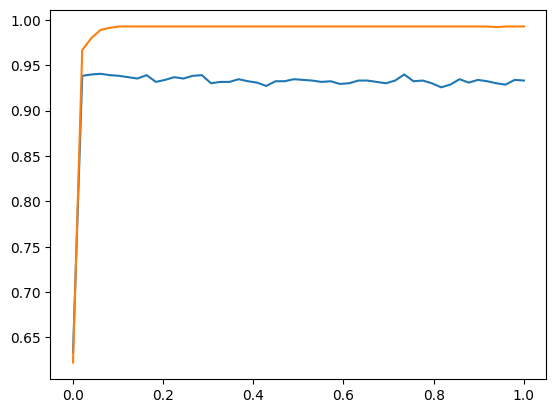

In [126]:
# plot
plt.plot(learning_rate, test_accuracy)
plt.plot(learning_rate, train_accuracy)


In [127]:
GBMTuned = GradientBoostingClassifier(max_depth = 6,
                                      n_estimators = 150,
                                      learning_rate = 0.06,
                                      random_state = 44)
GBMTuned.fit(X, y)
GBMPred = GBMTuned.predict(X_test)
GBMProb = GBMTuned.predict_proba(X_test)
GBMAcc = accuracy_score(y_test, GBMPred)

(knnAcc, DtreeAcc, RFAcc, GBMAcc)

(0.8007322175732218, 0.8519874476987448, 0.8739539748953975, 0.87918410041841)

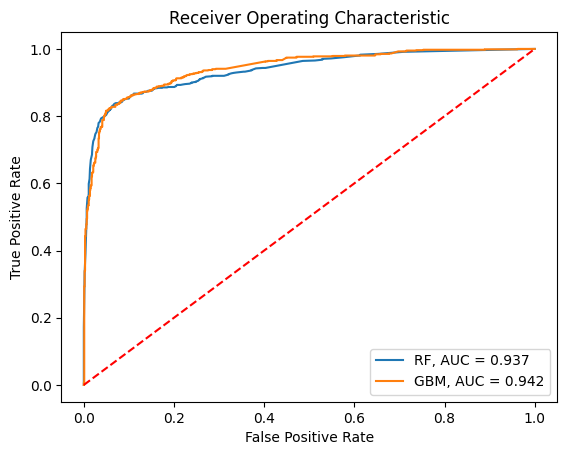

In [128]:
fpr_gbm, tpr_gbm, threshold_gbm = sklearn.metrics.roc_curve(y_test, GBMProb[:, 1])

roc_auc_gbm = sklearn.metrics.auc(fpr_gbm, tpr_gbm)


plt.plot(fpr_rf, tpr_rf, label = 'RF, AUC = %0.3f' % roc_auc_rf)
plt.plot(fpr_gbm, tpr_gbm, label = 'GBM, AUC = %0.3f' % roc_auc_gbm)
plt.plot([0,1], [0,1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Information gain to build a new branch
Feature selection at every node is performed by checking each candidate feature, and optimizing a possible cut-off threshold such that impurity is minimized, which is equivalent to say that the information gain is maximized.

The computation of information gain in one node is basically the difference between the impurity of the parent and the weighted impurity of the two children:

$$IG(D_p)= I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})$$

where $IG$ is information gain, $I$ a measure of impurity, $D_p$ dataset at parent level, $D_{left}$ and $D_{right}$ dataset at left and right child. $N_p$ number of observations at parent level, $N_{left}$ and $N_{right}$ number of observations at left and right child.

As measures of impurity ($I$), two of them are typically used for classification problems (entropy and Gini index), whereas *variance* is typically used for regression problems.


### Entropy
This measure comes from the field of information theory. Information entropy is the average rate at which information is produced by a stochastic source of data.

$$E(D)=\sum_{j=1}^k-p_{j}log_{2}p_{j}$$

where $k$ are the number of classes, and $p_j$ is the probability (or frequency of observations in our case) of class $j$.

### Gini 
Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 

$$G(D)=\sum_{j=1}^C\left(p_j\sum_{k\neq j}^Cp_k\right) = \sum_{j=1}^{C} p_j (1-p_j) 
 = 1 - \sum^{C}_{j=1} {p_j}^{2}$$ 

Gini is computationally faster than entropy.

### Comparison
Let's compare both measures for a binary classification case, together with a simple alternative that is the missclassification error, i.e. which is the in-sample error if we simply classify as the most frequent class:
$$ClassError=1-max(p_j)$$
$j \in \left\{1, ..., C\right\}$ (classes)

In a binary classification case, and rescaling entropy (divide by 2 so that maximum value is 0.5 as the other methods), we have the follwing plot. Entropy is the one that penalizes more the impurity, followed by Gini.


In [129]:
x = np.linspace(0.0001, 0.9999, 100)

entropy1 = [(-i)*math.log2(i) for i in x]
entropy2 = [(i-1)*math.log2(1-i) for i in x]
entropy = np.sum([entropy2, entropy1], axis = 0)

gini = 1-(x**2) - ((1-x)**2)
missclass = 1-np.max([x, 1-x], axis = 0)

Text(0, 0.5, 'Impurity')

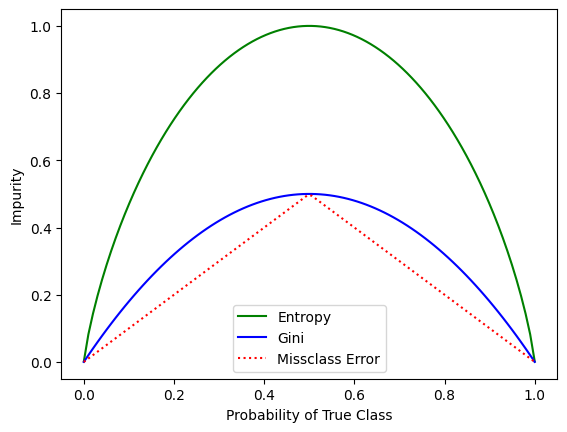

In [130]:
# plot
plt.plot(x, entropy, label = 'Entropy', color = 'green')
plt.plot(x, gini, label = 'Gini', color = 'blue')
plt.plot(x, missclass, label = 'Missclass Error', color = 'red', linestyle = 'dotted')
plt.legend()
plt.xlabel('Probability of True Class')
plt.ylabel('Impurity')

### Importance computation
Importance of each feature is computed by adding information gains of nodes related to a feature, first by tree (one importance per feature per tree):
$$FImp_{f_i,t_j}=\frac{\sum_{k=1}^{K_{i,j}}IG(D_{k,i,j})}{\sum_{l=1}^{K_{j}}IG(D_{l,i,j})}$$

$f_i$: $i_{th}$ feature; $t_j$: $j_{th}$ tree; $K_{i,j}$: number of nodes for feature *i* in tree *j*; $K_{j}$: number of nodes in tree *j*; 

Finally, per each feature we average $FImp$ by all trees:
$$FImp_{f_i}=\frac{\sum_{j=1}^{T}FImp_{f_i,t_j}}{\sum_{i=1}^{F}\sum_{j=1}^{T}FImp_{f_i,t_j}}$$
$T$: number of trees; $F$: number of features;

### Formulation
Main formulation differs from GBM because there is no need to split into two components (no $\rho$ and $\phi$):

$$f_t(\bf x)=f_{0}(\bf x)+ \sum_{m=1}^T \epsilon f_m(\bf x)$$

But what is more important is that a regularization function is added to the loss function (to take into account the complexity of each tree and hence prevent overfitting), so the objective function becomes:

$$ Obj= \sum_{i=1}^N L(y_i, f(x_i)) + \sum_{m=1}^T \Omega(f_m(x))$$

As reference, typical loss functions can be:
+ Square loss for regression:
$$L(y_i, f(x_i))= (y_i-f(x_i))^2$$
+ Logistic loss for binary classification: 
$$L(y_i, f(x_i))= y_i(ln(1+ e^{-f(x_i)}) + (1-y_i)(ln(1+ e^{f(x_i)})$$

For each tree, the complexity measure penalizes both the number of final regions $R$(leaves) and having high scores (predictions) in each leaf ($w_j$) :
$$ \Omega(f_m(x))= \gamma R + \frac{1}{2}\lambda \sum_{j=1}^R w_j^2 $$
$\gamma$ and $\lambda$ will be parameters to tune.

### Tree computation

After working out the optimization of the objective function applying a second order Taylor expansion of the loss function, one can show that, when building an extra tree, the optimum scores for our leaves would follow this formula:
$$ w_j*=-\frac{G_j}{H_j+ \lambda} $$
and the optimum value of the objective function will be:
$$ Obj= -\frac{1}{2} \sum_{j=1}^R \frac{G_j^2}{H_j+ \lambda} + \gamma R$$
being:
+ $G_j = \sum_{i\epsilon j} g_i$: the sum of all gradients of loss function for all observations in region *j* (i.e. $g(\bf x)=   \frac{\partial L(y, f(\bf x))}{\partial f(\bf x)}   $);
+ $H_j = \sum_{i\epsilon j} h_i$: the sum of second derivatives of loss function for all observations in region *j* (i.e. $h(\bf x)=   \frac{\partial^2 L(y, f(\bf x))}{\partial f(\bf x)}   $);

Building of a new branch (split) of a new tree *m* implies then the following steps:

1. Computing $g_i$ and $h_i$ values for all *n* observations of the dataset(using *m-1* trees, i.e. $f_{m-1}(x)$)

2. Finding best feature and best cut threshold, by scanning from left to right and computing changes in objective function (maximum Gain) 

<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/images/line_search_xgb.png">

$$Gain= \frac{G_{left}^2}{H_{left}+ \lambda} + \frac{G_{right}^2}{H_{right}+ \lambda} - \frac{(G_{left}+G_{right})^2}{H_{left}+H_{right}+ \lambda} - \gamma $$

3. If this Gain is positive, means this best cut would decrease our overall loss, so we can proceed to splitting. Note gains have to be high enough to compensate the penalization involved in $\lambda$ and $\gamma$ terms.
4. Once splitted, the correspoding scores of new leaves can be computed for each new leaf *j* simply as:
$$ w_j*=-\frac{G_j}{H_j+ \lambda} $$



### Xgboost example
Let's code a simple example of Xgboost, using our well know spam dataset

In [131]:
# load packages
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [132]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_model = xgb.XGBClassifier()

In [133]:
parameters = {'learning_rate': [0.05, 0.15, 0.25, 0.5],
              'max_depth': [5],
              'n_estimators': [100, 150]}

clf = GridSearchCV(xgb_model,
                   parameters,
                   n_jobs = 3,
                   cv = 5,
                   scoring = 'roc_auc',
                   verbose = 0,
                   refit = True)

clf.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=3,
             param_grid={'learning_rate': [0.05, 0.15, 0.25, 0.5],
                         'max_depth': [5], 'n_estimators': [100, 150]},
             scoring='roc_auc')

In [134]:
clf.best_params_, clf.best_score_

({'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150},
 0.9733921699034742)

In [135]:
# test results
xgbProb = clf.predict_proba(X_test)
xgbPred = clf.predict(X_test)
xgbAcc = accuracy_score(y_test, xgbPred)
fpr_xgb, tpr_xgb, threshold_xgb = sklearn.metrics.roc_curve(y_test, xgbProb[:, 1])

roc_auc_xgb = sklearn.metrics.auc(fpr_xgb, tpr_xgb)

In [136]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'True Positive Rate')

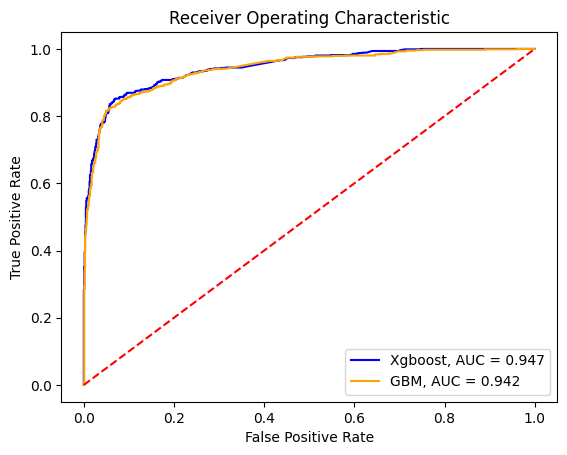

In [137]:
plt.plot(fpr_xgb, tpr_xgb, 'b', label = 'Xgboost, AUC = %0.3f' % roc_auc_xgb)
plt.plot(fpr_gbm, tpr_gbm, 'orange', label = 'GBM, AUC = %0.3f' % roc_auc_gbm)
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')

In [138]:
knnAcc, DtreeAcc, RFAcc, GBMAcc, xgbAcc

(0.8007322175732218,
 0.8519874476987448,
 0.8739539748953975,
 0.87918410041841,
 0.8891213389121339)

In [149]:
# feature importance
my_model = xgb.XGBClassifier()
my_model.fit(X,y)

aux = pd.DataFrame(zip(feature_names,
                       my_model.feature_importances_),
                   columns = ['Features', 'Importances'])

aux = aux.sort_values(['Importances'], ascending = False)
aux['Importances'] = 100*aux['Importances']/aux['Importances'].max()
aux

Features  Importances
9   word_freq_remove   100.000000
0   word_freq_george    85.692856
10       char_freq_!    66.040268
3       word_freq_hp    58.425419
2     word_freq_your    24.673439
8      word_freq_edu    22.662327
5      word_freq_hpl    20.707226
4     word_freq_free    18.250290
7       word_freq_re    15.915233
6      word_freq_our    12.962622
1      word_freq_you     9.179626

[Text(0, 0, 'word_freq_remove'),
 Text(1, 0, 'word_freq_george'),
 Text(2, 0, 'char_freq_!'),
 Text(3, 0, 'word_freq_hp'),
 Text(4, 0, 'word_freq_your'),
 Text(5, 0, 'word_freq_edu'),
 Text(6, 0, 'word_freq_hpl'),
 Text(7, 0, 'word_freq_free'),
 Text(8, 0, 'word_freq_re'),
 Text(9, 0, 'word_freq_our'),
 Text(10, 0, 'word_freq_you')]

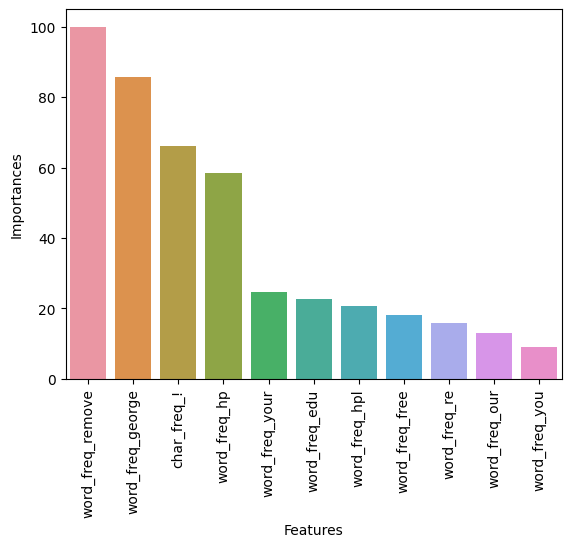

In [153]:
import seaborn as sns
ax = sns.barplot(x = 'Features',
                 y = 'Importances',
                 data = aux)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

### Classification trees: Majority vote variations
Once our set of trees has been built, final predictions are obtained by simply picking the majority vote (mode) of the resultant outputs.

Nevertheless, in actual implementation of most methods (e.g. random forest) at sklearn, instead of the mode, the algorithm performes a probability per class at each tree (frequency of training samples per class at final leaf). Final prediction is then the class with higher average probability, thus allowing to output probabilities as well.

On the other hand, in boosting, there is a different weight per leaf per tree in final computation, that has been optimized to minimize an overall loss function.

<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/images/sample_tree_computation.png">

Figure [source](https://web.njit.edu/~usman/courses/cs675_fall16/BoostedTree.pdf).

In this sample binary classification case the predicted probability of class 1 for the boy would be $ \frac{1}{1+ e^{2.9}}=0.948 $

### References

Skit-Learn documentation. Ensemble methods. https://scikit-learn.org/stable/modules/ensemble.html#

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html

### Some hints for practitioners

### Models
#### CART (single tree)
Use *sklearn* function $DecisionTreeClassifier$ for classification, or $DecisionTreeRegressor$ for regression. These models are simpler to understand and explore but typically **yield worse results than the ones based on 'multiple tree' approach**. Some interesting parameters  to tune (for classification) are:
+ *max_depth*: Number of levels in a tree
+ *min_samples_split*: Minimum number of samples left to try a new split
+ *min_samples_leaf*: Minimum number of samples allowed in a leaf
+ *min_impurity_decrease*: Don't accept the split if we don't reach a minimum decrease in impurity
+ *min_impurity_split*: Early stop criteria, don't split if mininum impurity has been reached
+ *class_weight*: Use 'balanced' if classes are unbalanced.


#### Random forest
Use *sklearn* function $RandomForestClassifier$ for classification, or $RandomForestRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *max_features*: Number of features to consider when looking for the best split. If less than 100%, this intruduces stochasticity.
+ *boostrap*: Keep default 'True' to allow boostrapping the sample for each tree, useful to prevent overfitting
+ *oob_score*: If True, yields a proxy for expected accuracy, using *
* observations per tree.
+ *n_jobs*: Number of CPU cores to be used (parallelization).
+ *max_depth*, *min_samples_split*, *min_impurity_decrease*, *min_impurity_split*, *class_weight*: Similar to CART


#### AdaBoost
Use *sklearn* function $AdaBoostClassifier$ for classification, or $AdaBoostRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *learning_rate*: Intensity of the re-weighting (boosting) each time we build a new tree.
+ 'base_estimator': Weak learner, by default 'DecisionTreeClassifier(max_depth=1)', but one can for instance increase depth to check if this helps.

#### GradientBoosting (GBM)
Use *sklearn* function $GradientBoostingClassifier$ for classification, or $GradientBoostingRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *subsample*: Percentage of samples to use for every tree.
+ *learning_rate*: similar to AdaBoost
+ *max_features*,*max_depth*, *min_samples_split*, *min_impurity_decrease*, *min_impurity_split*, *class_weight*: Similar to random forest

#### Extreme Gradient Boosting (XGBoost)
Use *xgboost* package and follow documentation at https://xgboost.readthedocs.io/en/latest/python/

Main functions are $xgboost.XGBClassifier$ or $xgboost.XGBRegressor$, which are an API to be used with *sklearn*.

Main parameters are:
+ *gamma*: similar to min_impurity_decrease. Minimum loss reduction required to make a further partition on a leaf node of the tree.
+ *colsample_bytree*:  Percentage of features to consider when constructing each tree.
+ *reg_alpha*:  L1 regularization term on weights to control overfitting
+ *reg_lambda*: L2 regularization term on weights to control overtiffing
+ *n_estimators*,*subsample*, *learning_rate*,*max_depth*: Similar to Gradient Boosting. 

#### Other MART (Multiple Additive Regression Trees) models:
+ *ligthgbm* package: Computationally faster than GBM, https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
+ *catboost* package: Computationally faster than GBM, able to manage categorical variables, allows using GPU, https://github.com/catboost/catboost and https://catboost.ai/
+ Extremely Randomized Trees: Similar to random forest but optimization of splits is based on discrete random thresholds instead of exploring the entire space, so it's faster (and sometimes more accurate since is less prone to overfit). Use *sklearn* function $ExtraTreesClassifier$ or *ExtraTreesRegressor*

### Hyperparameter optimization
Use *sklearn* functions such as $GridSearchCV$ or $RandomizedSearchCV$. See example above in random forest section.